# Проектная работа 

## По дисциплине технологии машинного обучения и нейросети для решения прикладных задач

### Работу выполнил Пьянков Марк Олегович студент 4 курса направления "Компьютерная безопасность" Пермского Государственного национального исследовательского университета

## Тема работы: Определение переломов костей на рентгеновском снимке с помощью инструментов машинного обучения и нейросетей. 



## Датасет - Bone Fracture Multi-Region X-ray Data
#### многорегиональные ренгеновские снимки переломов костей

This dataset contains 10,580 radiographic images

- Training Data Number of Images: 9246
- Validation Data Number of Images: 828
- Test Data Number of Images: 506

## План работы

1) Изучаем датасет
5) Тренируем модели, проводим исследования
6) Выводы

# Посмотрим на датасет

## Проверим какого разрешения у нас есть снимки

In [2]:
import os
from collections import Counter
import pandas as pd
from PIL import Image

# Путь к директории с данными
data_dir = "data"

# Словарь для подсчёта количества изображений каждого разрешения
resolution_counts = Counter()

# Проход по всем файлам в директории
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(root, file)
            try:
                with Image.open(img_path) as img:
                    resolution_counts[img.size] += 1  # img.size -> (width, height)
            except Exception as e:
                print(f"Ошибка с файлом {img_path}: {e}")


df = pd.DataFrame(resolution_counts.items(), columns=["Разрешение", "Количество изображений"])

# Сортировка по количеству изображений
df = df.sort_values(by="Количество изображений", ascending=False)

df.head(20)

,Разрешение,Количество изображений
0,"(224, 224)",9512
5,"(373, 454)",110
15,"(2304, 2880)",94
8,"(100, 100)",31
16,"(454, 373)",25
104,"(2320, 2920)",24
40,"(1946, 1557)",15
39,"(846, 1498)",14
10,"(834, 1514)",13
2,"(2328, 2928)",12


In [3]:
# Всего изображений
df['Количество изображений'].sum()

np.int64(10581)

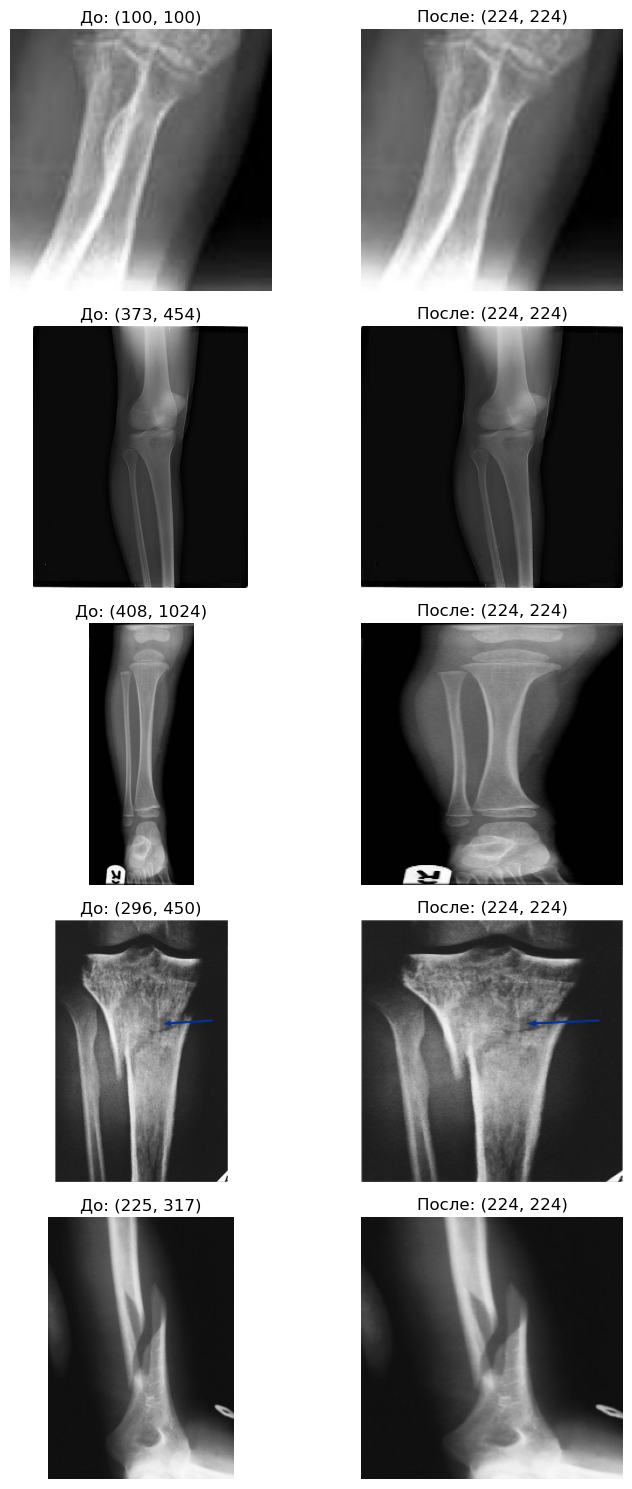

In [4]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Путь к директории с данными
data_dir = "data"

# Целевой размер
TARGET_SIZE = (224, 224)

# Функция для поиска изображений с размером != 224x224
def find_non_target_size_images(root_dir, target_size):
    non_target_images = []
    
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(root, file)
                try:
                    with Image.open(img_path) as img:
                        if img.size != target_size:  # (width, height)
                            non_target_images.append(img_path)
                except Exception as e:
                    print(f"Ошибка с файлом {img_path}: {e}")

    return non_target_images

# Найти изображения, не равные 224x224
non_target_images = find_non_target_size_images(data_dir, TARGET_SIZE)

# Выбираем 5 случайных изображений
random_images = random.sample(non_target_images, min(5, len(non_target_images)))

# Функция для отображения изображений до и после ресайза
def show_images_before_after_resize(image_paths, target_size):
    fig, axes = plt.subplots(len(image_paths), 2, figsize=(8, len(image_paths) * 3))

    for i, img_path in enumerate(image_paths):
        # Открываем оригинальное изображение
        img = Image.open(img_path)
        original_size = img.size  # (width, height)

        # Преобразуем с помощью OpenCV
        img_cv = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        img_resized = cv2.resize(img_cv, target_size)

        # Конвертируем BGR в RGB для отображения в matplotlib
        img_cv_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
        img_resized_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

        # Отображаем оригинальное изображение
        axes[i, 0].imshow(img_cv_rgb)
        axes[i, 0].set_title(f"До: {original_size}")
        axes[i, 0].axis("off")

        # Отображаем изображение после ресайза
        axes[i, 1].imshow(img_resized_rgb)
        axes[i, 1].set_title(f"После: {target_size}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Показать изображения
show_images_before_after_resize(random_images, TARGET_SIZE)


In [6]:
import zipfile
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split
from PIL import ImageFile
import time
import torch.nn as nn
import os
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import torchvision
from torchinfo import summary
from torch.utils import data
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from glob import glob
from itertools import chain


### Как оказалось не все изображения целые, придётся удалить, которые не могут быть открыты. (таких всего 5 штук)

In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True # Для корректной обработки изображений

dataset_path = "data"

dataset_path
for root, _, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)
            img.verify()  # Проверка целостности изображения
        except (IOError, OSError):
            print(f"Найдено поврежденное изображение, удаляем: {file_path}")

            os.remove(file_path)  # Удаление поврежденного файла

### Инициализируем датасеты через DataLoader для удобной работы с ними во время обучения.

In [9]:
train_dir = './data/train/'
test_dir = './data/test/'
val_dir = './data/val/'

mean = [0.2328, 0.2328, 0.2328]
std = [0.0350, 0.0350, 0.0350]

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing images
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=mean, std=std),
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

batch_size=32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Модели для исследования:
### 1. SVM
### 3. CNN ResNet 
### 4. CNN EfficientNet в двух вариантах


## Критерии качества решения задачи:
### Precision Доля правильных положительных предсказаний среди всех предсказанных положительных случаев.

### В качетсве первой модели вомьзём ResNet18

In [10]:
lr = 0.001  
epochs = 15
device = torch.device("cpu")

model = models.resnet18(weights=None)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # общее кол-во примеров в датасете
    sum_loss = 0 # переменная для накопления ошибки за эпоху
    
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        start_time = time.time()

        pred = model(X) 

        # ДЛЯ EFFb0
        pred = pred.squeeze(1)  # преобразуем в одномерный тензор: (batch_size,)
        y = y.float()  # Преобразуем метки в float32
        # ------
        
        loss = loss_fn(pred, y) # считаем ошибку.
        sum_loss += loss.item() 

        loss.backward() # вычисляет градиенты (как менять веса, чтобы уменьшить ошибку).
        optimizer.step() # обновляет веса модели.
        optimizer.zero_grad() # очищает старые градиенты

        end_time = time.time()
        batch_time = end_time - start_time

        # Для отслеживания прогресса
        print("Время обработки батча: ",  batch_time)
        if batch % 30 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
def test_loop(dataloader, model, loss_fn):
    
    model.eval() 

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # correct — переменная для подсчёта количества правильных предсказаний.
    # test_loss — переменная для хранения суммарной потери (ошибки) на тестовых данных.


    # отключаем вычисление градиентов
    # Во время тестирования нам не нужны градиенты, 
    # поскольку мы не обновляем веса модели, а просто оцениваем её производительность.
    with torch.no_grad():
        for X, y in dataloader:
            
            pred = model(X)
            # ДЛЯ EFFb0
            pred = pred.squeeze(1)  # преобразуем в одномерный тензор: (batch_size,)
            y = y.float()  # Преобразуем метки в float32
            # ------


            test_loss += loss_fn(pred, y).item()

            # ------
            # Для бинарной классификации вместо argmax() сравниваем с 0.5
            correct += ((pred > 0.5) == y).sum().item()
            # ------

            
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # pred.argmax(1) == y сравнивает предсказанный класс с истинным классом. 
    # argmax(1) находит индекс с максимальной вероятностью 
    # для каждого предсказания (класс, который модель считает наиболее вероятным). 
    # Если предсказанный класс совпадает с истинным, то это правильно классифицированный пример. 

    test_loss /= num_batches # средняя ошибка
    correct /= size # точность
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [11]:
def run_training(epochs, train_dataloader, model, criterion, optimizer):
    # списки для хранения потерь
    test_loss = [] 
    train_loss = []
    
    # цикл по эпохам
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        
        # обучение
        sum_loss = train_loop(train_dataloader, model, criterion, optimizer)
        train_loss.append(sum_loss)

        # тест
        acc, avg_loss = test_loop(test_loader, model, criterion)
        test_loss.append(avg_loss)
    print("Done!")
    
    return test_loss

In [ ]:
test_loss_sgd = run_training(epochs, train_loader, model, criterion, optimizer)

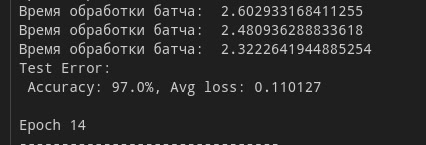

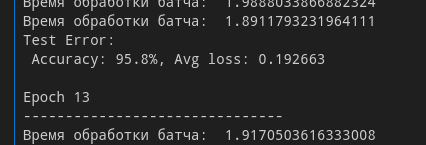

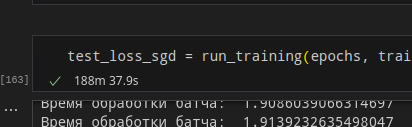

#### Сохраним модель

In [165]:
torch.save(model, 'first_try.pth')
# /home/cartman/actual/neuro/project/first_try

## В качестве следующей модели возьмём efficientnet_b0, с заранее обученными весами

In [ ]:
# Юзаем предобученную модель

lr = 0.001  
epochs = 3
device = torch.device("cpu")

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

model.to(device)

# Меняем "голову" модели
num_features = model.classifier[1].in_features  
model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 1),
    nn.Sigmoid()  
)
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:

# Оптимайзер только для "головы"
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=lr, weight_decay=1e-4)

# Функция потерь
criterion = nn.BCELoss()  # так как Sigmoid в конце

# Запускаем обучение
effnet = run_training(epochs, train_loader, model, criterion, optimizer)

In [1]:
import os
import random
import numpy as np
import cv2

# Нормализованные значения для каналов
mean = [0.2328, 0.2328, 0.2328]
std = [0.0350, 0.0350, 0.0350]

# Функция для извлечения HOG-признаков из изображения
def extract_hog(image_path):
    
    img = cv2.imread(image_path)  # Чтение изображения с помощью OpenCV
    if img is None:
        print(f"Ошибка загрузки изображения: {image_path}")
        return None  # Возвращаем None, если изображение не загружено
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Конвертация из BGR в RGB

    # Изменение размера до 224x224
    img_resized = cv2.resize(img, (224, 224))

    # Нормализация изображения по заданным mean и std
    #img_normalized = (img_resized / 255.0 - mean) / std  # Нормализация (0-255 в [0, 1] -> нормализация по mean и std)
    
    # Приводим изображение к типу float32
    #img_normalized = img_normalized.astype(np.float32)

    # Переводим изображение в оттенки серого для HOG
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)

    # Инициализация HOG дескриптора OpenCV
    hog_descriptor = cv2.HOGDescriptor()
    hog_features = hog_descriptor.compute(gray)  # Извлекаем HOG-признаки
    return hog_features.flatten()  # Преобразуем в одномерный массив


# Функция для извлечения данных из папки с случайным выбором изображений
def extract_data_from_folder(folder_path, max_images=None):
    features, labels = [], []
    
    # Проходим по всем файлам в папке
    for label_folder in os.listdir(folder_path):
        label_folder_path = os.path.join(folder_path, label_folder)
        if os.path.isdir(label_folder_path):  # Только директории
            image_paths = [os.path.join(label_folder_path, image_name)
                           for image_name in os.listdir(label_folder_path)
                           if image_name.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Случайно выбираем max_images (если указано), иначе все изображения
            if max_images:
                image_paths = random.sample(image_paths, min(max_images, len(image_paths)))
            
            for image_path in image_paths:
                features_ = extract_hog(image_path)
                if features_ is not None:  # Если изображение было успешно загружено
                    features.append(features_)  # Извлекаем HOG-признаки
                    labels.append(label_folder)  # Метка класса (имя папки)
    
    return np.array(features), np.array(labels)

# Директории
train_dir = './data/train/'
test_dir = './data/test/'
#val_dir = './data/val/'

# Извлекаем данные (5000 случайных изображений из train, все из test)
X_train, y_train = extract_data_from_folder(train_dir, max_images=500)
X_test, y_test = extract_data_from_folder(test_dir)

# Проверка размеров извлеченных данных
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

libpng warning: bKGD: invalid


Ошибка загрузки изображения: ./data/train/fractured/2.jpg


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Training set shape: (999, 1031940)
Test set shape: (506, 1031940)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Обучение SVM
svm = SVC(kernel="linear", C=1.0)
svm.fit(X_train, y_train)

# Оценка точности
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность SVM: {accuracy:.2f}")


# Feature shape: (26244,)
# Training set shape: (800, 26244)
# Test set shape: (506, 26244)
# .*.*
# optimization finished, #iter = 1995
# obj = -1.107294, rho = -0.076011
# nSV = 550, nBSV = 0
# Total nSV = 550
# [LibSVM]Точность SVM: 0.86


# Training set shape: (1000, 26244)
# Test set shape: (506, 26244)
# .*.*
# optimization finished, #iter = 2550
# obj = -1.311347, rho = 1.012254
# nSV = 664, nBSV = 0
# Total nSV = 664
# [LibSVM]Точность SVM: 0.90


# Training set shape: (1599, 26244)
# Test set shape: (506, 26244)
# ..*.*
# optimization finished, #iter = 3683
# obj = -1.803727, rho = 0.277083
# nSV = 890, nBSV = 0
# Total nSV = 890
# [LibSVM]Точность SVM: 0.92


# Training set shape: (2000, 26244)
# Test set shape: (506, 26244)
# ..*..*
# optimization finished, #iter = 4075
# obj = -1.956823, rho = 0.304203
# nSV = 991, nBSV = 0
# Total nSV = 991
# [LibSVM]Точность SVM: 0.92


# Training set shape: (1998, 26244)
# Test set shape: (506, 26244)
# ..*..*
# optimization finished, #iter = 4019
# obj = -1.964103, rho = 1.157959
# nSV = 1008, nBSV = 0
# Total nSV = 1008
# [LibSVM]Точность SVM: 0.89

